In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Прототип генерации блуждания и подсчёта соседей по нему

In [ ]:
np.random.randint(0,4, size=10)

array([2, 2, 2, 1, 3, 3, 2, 1, 2, 0])

Основные константы - начальная точка и шаги блуждания

In [ ]:
x0 = np.array([0,0])
steps = np.array([[1,0],[-1,0],[0,1],[0,-1]])

Генерация блужданий и определение уникальных узлов

In [ ]:
N=100
walk_directions = np.random.randint(0,4, size=N)
walk_dots = np.zeros((N, 2), dtype=np.int16)
walk_dots[0] = x0

for i in range(1,N):
    walk_dots[i] = walk_dots[i-1] + steps[walk_directions[i]]

walk_dots_new = np.unique(walk_dots, axis=0)
N_new = len(walk_dots_new)

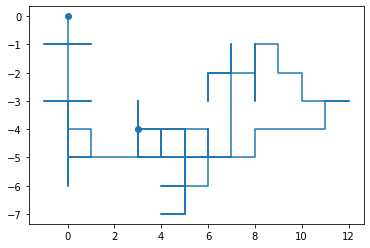

In [ ]:
plt.plot(walk_dots[:,0], walk_dots[:,1])
plt.scatter(walk_dots[(0,-1),0], walk_dots[(0, -1),1])

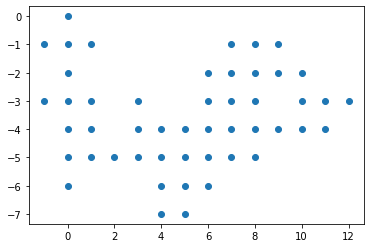

In [ ]:
plt.scatter(walk_dots_new[:,0], walk_dots_new[:,1])

Подсчёт соседей среди уникальных узлов

In [ ]:
walk_neighbors = np.zeros((N_new,), dtype=np.int8)
for i in range(N_new):
    for step in steps:
        potential_n = walk_dots_new[i] + step
        for j in range(N_new):
            if (walk_dots_new[j] == potential_n).all():
                walk_neighbors[i] += 1
                break

In [ ]:
walk_neighbors

array([1, 1, 1, 3, 3, 4, 2, 4, 1, 3, 3, 2, 1, 2, 3, 3, 1, 2, 3, 4, 3, 2,
       4, 4, 3, 2, 4, 4, 3, 2, 3, 4, 4, 4, 2, 2, 4, 3, 4, 3, 2, 3, 2, 3,
       3, 2, 2, 3, 1], dtype=int8)

In [ ]:
neigh_fract = np.zeros((1,4), dtype=np.float)
for i in range(1,4+1):
    neigh_fract[0][i-1] = (walk_neighbors == i).sum()
neigh_fract / N_new

array([[0.14285714, 0.26530612, 0.34693878, 0.24489796]])

# Распараллеленный алгоритм

In [ ]:
from numba import njit, jit, prange
from tqdm import trange

@jit
def experiment(N: int):
    x0 = np.array([0,0])
    steps = np.array([[1,0],[-1,0],[0,1],[0,-1]])
    walk_directions = np.random.randint(0,4, size=N)
    walk_dots = np.zeros((N, 2), dtype=np.int16)
    walk_dots[0] = x0
    for i in range(1,N):
        walk_dots[i] = walk_dots[i-1] + steps[walk_directions[i]]
        
    walk_dots_new = np.unique(walk_dots, axis=0)
    N_new = len(walk_dots_new)
    walk_neighbors = np.zeros((N_new,), dtype=np.int8)
    
    for i in range(N_new):
        for step in steps:
            potential_n = walk_dots_new[i] + step
            for j in range(N_new):
                if (walk_dots_new[j] == potential_n).all():
                    walk_neighbors[i] += 1
                    break    
    
    neigh_fract_0 = np.zeros((4,), dtype=float)
    for i in range(1,4+1):
        neigh_fract_0[i-1] = (walk_neighbors == i).sum()
    return neigh_fract_0 / N_new

def complex_experiment(K, N):
    neigh_fract = np.zeros((K,4), dtype=float)
    for i in trange(K):
        neigh_fract[i] = experiment(N)
    return neigh_fract.mean(axis=0), neigh_fract.std(axis=0)

In [ ]:
%%time 

print('\n',*complex_experiment(10, 1000))

100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


 [0.03908428 0.22713298 0.32627724 0.4075055 ] [0.01144989 0.03751134 0.02890285 0.05406275]
CPU times: user 907 ms, sys: 12.6 ms, total: 920 ms
Wall time: 1.25 s


In [ ]:
for N in [100, 200, 500, 750, 1000, 2000]:
    print(N, complex_experiment(10000, N))

100%|██████████| 10000/10000 [00:12<00:00, 784.47it/s]


100 (array([0.06784209, 0.33472285, 0.35761886, 0.2398162 ]), array([0.03329051, 0.08660281, 0.06659357, 0.09192897]))


100%|██████████| 10000/10000 [00:30<00:00, 323.09it/s]


200 (array([0.05252419, 0.29084858, 0.35422398, 0.30240324]), array([0.02219834, 0.07080206, 0.05464862, 0.08984867]))


100%|██████████| 10000/10000 [01:58<00:00, 84.62it/s]


500 (array([0.03945975, 0.24373265, 0.33940513, 0.37740246]), array([0.01402355, 0.0539927 , 0.04393788, 0.08208375]))


100%|██████████| 10000/10000 [03:32<00:00, 47.12it/s]


750 (array([0.03568031, 0.22677461, 0.33144464, 0.40610044]), array([0.01157634, 0.04805729, 0.04056382, 0.07818883]))


100%|██████████| 10000/10000 [05:32<00:00, 30.11it/s]


1000 (array([0.03326473, 0.21687621, 0.3263666 , 0.42349246]), array([0.01010491, 0.04449639, 0.03842001, 0.07505321]))


100%|██████████| 10000/10000 [16:59<00:00,  9.81it/s]

2000 (array([0.02878497, 0.19461286, 0.31191969, 0.46468249]), array([0.007529  , 0.0360762 , 0.03342942, 0.06610401]))


In [ ]:
complex_experiment(10000, 10000)

100%|██████████| 10000/10000 [05:11<00:00, 32.10it/s]


array([0.0332595 , 0.21601091, 0.32574161, 0.42498798])

In [ ]:
f = open('text.txt', 'w')
values, errors = complex_experiment(10000, 100)
f.write(str(values)+'\n')
f.write(str(errors))
f.close()

100%|██████████| 10000/10000 [00:09<00:00, 1047.18it/s]


In [47]:
y_100, dy_100 = np.array([0.06784209, 0.33472285, 0.35761886, 0.2398162 ]), np.array([0.03329051, 0.08660281, 0.06659357, 0.09192897])
y_200, dy_200 = np.array([0.05252419, 0.29084858, 0.35422398, 0.30240324]), np.array([0.02219834, 0.07080206, 0.05464862, 0.08984867])
y_500, dy_500 = np.array([0.03945975, 0.24373265, 0.33940513, 0.37740246]), np.array([0.01402355, 0.0539927 , 0.04393788, 0.08208375])
y_750, dy_750 = np.array([0.03568031, 0.22677461, 0.33144464, 0.40610044]), np.array([0.01157634, 0.04805729, 0.04056382, 0.07818883])
y_1000, dy_1000 = np.array([0.03326473, 0.21687621, 0.3263666 , 0.42349246]), np.array([0.01010491, 0.04449639, 0.03842001, 0.07505321])
y_2000, dy_2000 = np.array([0.02878497, 0.19461286, 0.31191969, 0.46468249]), np.array([0.007529  , 0.0360762 , 0.03342942, 0.06610401])

In [51]:
y = np.array([y_100, y_200, y_500, y_750, y_1000, y_2000])
dy = np.array([dy_100, dy_200,dy_500, dy_750, dy_1000, dy_2000])
x = 1/np.array([100, 200, 500, 750, 1000, 2000])

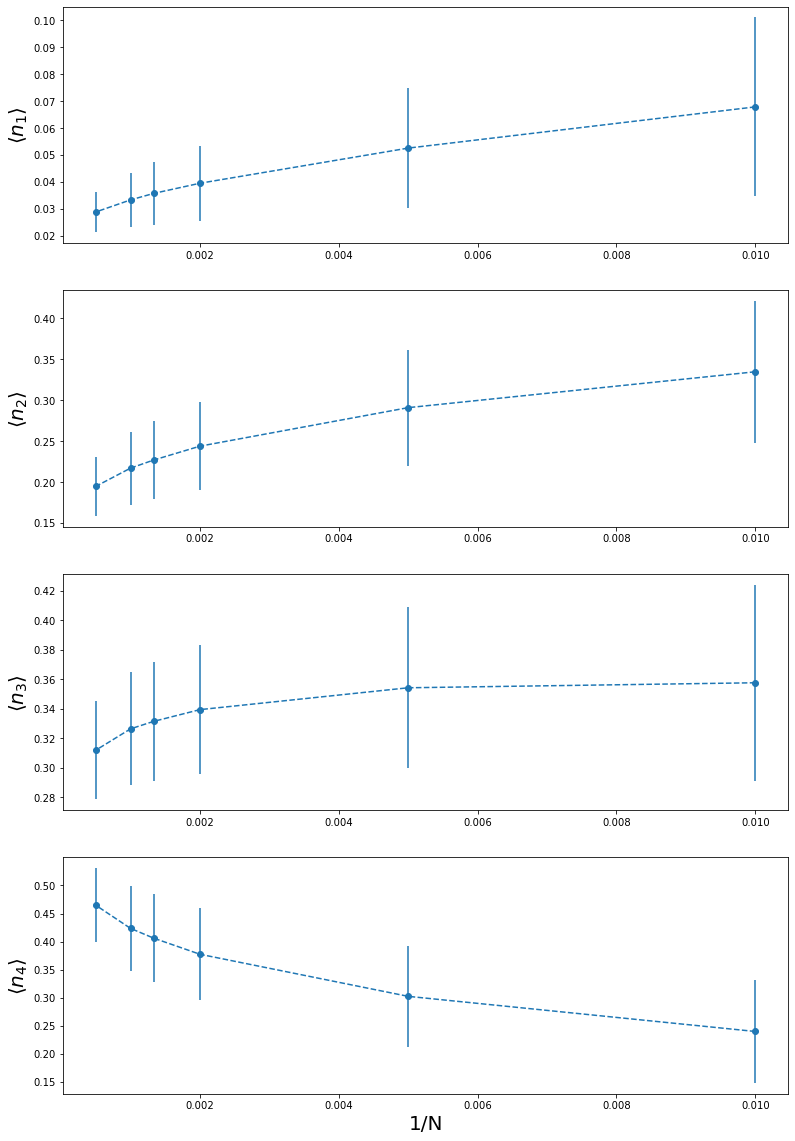

In [66]:
fig, ax = plt.subplots(4,1, figsize=(13,20))
for i in range(4):
    ax[i].errorbar(x, y[:,i], dy[:,i], fmt='o--')
    ax[i].set_ylabel(fr'$\langle n_{i+1} \rangle$', fontsize=20)
ax[-1].set_xlabel('1/N', fontsize=20)
plt.savefig(DIR / 'Images' / 'Rand_Path_N1-4.png')

In [4]:
from pathlib import Path

In [29]:
DIR = Path.cwd().parent / 'Simulation Results' / 'Geo_Rand_Walk_2D'
files = list(DIR.glob('*.*'))
df = np.array([np.loadtxt(files[0], skiprows=1)])
for f in files[1:]:
    df_0 = np.loadtxt(f, skiprows=1)
    df = np.append(df, [df_0], axis=0)
df = df[np.argsort(df[:,0])]
df

array([[1.00000e+02, 6.76790e-02, 3.35225e-01, 3.57299e-01, 2.39797e-01,
        4.90873e-01, 3.31510e-02, 8.72760e-02, 6.69380e-02, 9.21350e-02,
        8.24760e-02, 7.45000e+06],
       [2.00000e+02, 5.22460e-02, 2.90435e-01, 3.53759e-01, 3.03560e-01,
        4.44411e-01, 2.24360e-02, 7.04110e-02, 5.45100e-02, 8.94710e-02,
        6.95670e-02, 5.68400e+06],
       [5.00000e+02, 3.95950e-02, 2.44207e-01, 3.39629e-01, 3.76569e-01,
        3.94376e-01, 1.39520e-02, 5.36890e-02, 4.37970e-02, 8.17250e-02,
        5.62830e-02, 2.04500e+06],
       [1.00000e+03, 3.33360e-02, 2.16956e-01, 3.26085e-01, 4.23622e-01,
        3.63321e-01, 1.00950e-02, 4.41970e-02, 3.81730e-02, 7.44990e-02,
        4.83520e-02, 6.54000e+05],
       [2.50000e+03, 2.74980e-02, 1.88167e-01, 3.07111e-01, 4.77224e-01,
        3.28680e-01, 6.89600e-03, 3.45950e-02, 3.25890e-02, 6.49280e-02,
        4.01060e-02, 1.32000e+05],
       [5.00000e+03, 2.43340e-02, 1.71063e-01, 2.93280e-01, 5.11323e-01,
        3.06932e-01, 5

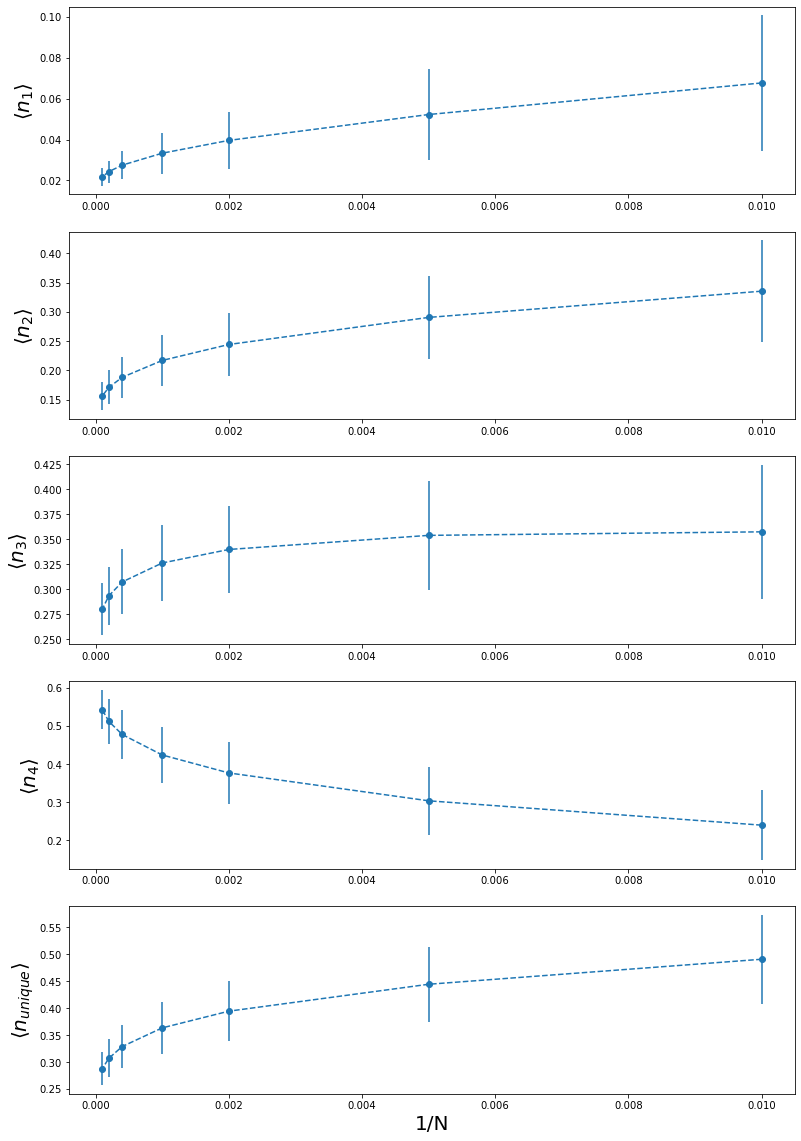

In [35]:
fig, ax = plt.subplots(5,1, figsize=(13,20))
x = 1/df[:,0]
for i in range(5):
    y = df[:,i+1]
    dy = df[:,5+i+1]
    ax[i].errorbar(x, y, dy, fmt='o--')
    if i < 4:
        ax[i].set_ylabel(fr'$\langle n_{i+1} \rangle$', fontsize=20)
    else:
        ax[i].set_ylabel(r'$\langle n_{unique} \rangle$', fontsize=20)
ax[-1].set_xlabel('1/N', fontsize=20)
plt.savefig(Path.cwd() / 'Images' / 'Rand_Path_N1-4_unique.png')